# Cell Proximity Effect Analysis

This notebook contains all experiments relating to computing and characterizing cell proximity effects across the coronal sections dataset. It uses the spatial aging clocks to compute age acceleration for the analysis.

**Associated manuscript figures/tables:**
- Figures: 4b,c,d,g
- Extended Data Figures: 9c,d
- Supplementary Table 14


**Inputs required:**
- `results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad` - AnnData object for coronal sections data with spatial aging clock predictions (generated from `cv_train_clock.py`)


**Conda environment used**: `requirements/merfish.txt`

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree

from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
from decimal import Decimal

from ageaccel_proximity import *

In [3]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

In [4]:
# Distance Cutoff Parameters -- see 5A_regional_proximity_distance_cutoffs.ipynb

cutoff = {'CC/ACO': 24.887910095931538, 'CTX_L1/MEN': 25.91425280674148, 'CTX_L2/3': 24.04649324744985, 'CTX_L4/5/6': 27.243990001598508, 'STR_CP/ACB': 21.6499141249257, 'STR_LS/NDB': 20.355186196238336, 'VEN': 17.863153902391776}

# Cell proximity age acceleration analysis

In [4]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

In [8]:
# compute age acceleration
get_age_acceleration (adata)

## Proximity Analysis (Region-matched)

Controlling for region by matching each nearby cell with one far cell (but within the same region)

In [9]:
# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

In [10]:
# Compute proximity stats

cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']
###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))

/local/scratch/edsun/slrmtmp.42816554/ipykernel_123395/3434506277.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")


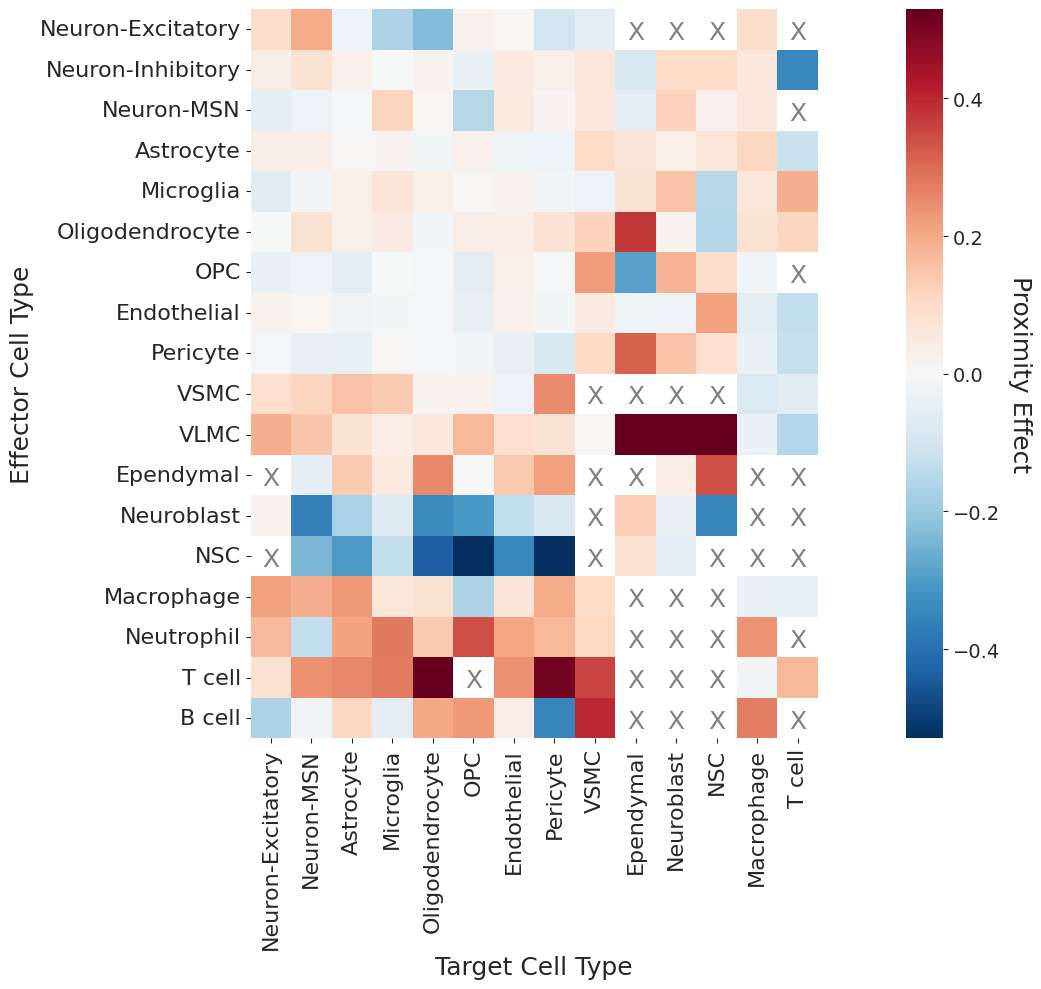

In [11]:
# Heatmap visualization of all proximity effects

comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
comb_df_sub["Near Cell"] = comb_df_sub["Near Cell"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in comb_df_sub['Near Cell'].values])
comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in comb_df_sub['AgeAccel Cell'].values])

pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

fig, ax = plt.subplots(figsize=(18,10))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98),
            vmax=np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98))

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=18)
plt.xlabel("Target Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_ttest_heatmap_ALL_spatialsmooth_regionmatchedfarthest_cohensd.pdf",
          bbox_inches='tight')
plt.show()

In [14]:
# Save results

comb_df_sub.to_csv("results/proximity/cell_proximity_results.csv", index=False)

In [50]:
# Number of detected proximities by relation

pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Near Num")

pivot_df

/local/scratch/edsun/slrmtmp.41934636/ipykernel_36433/3628276815.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Near Num")


AgeAccel Cell      Neuron-Excitatory  Neuron-MSN  Astrocyte  Microglia  \
Near Cell                                                                
Neuron-Excitatory               1549         186       2885        789   
Neuron-Inhibitory              72475         424      18505       6608   
Neuron-MSN                       206        2788       2037        609   
Astrocyte                      88084       27432      41793      14725   
Microglia                      39814       12207      18592       5993   
Oligodendrocyte                52107       23443      27985      10723   
OPC                            22360        6707      11647       4214   
Endothelial                    91750       24041      40467      15398   
Pericyte                       23353        6108       9955       4343   
VSMC                            3490         889       2860        830   
VLMC                            3144         891       5054       1433   
Ependymal                          5         327       1113        132   
Neuroblast                        61         389       1363        174   
NSC                                5         242        949        135   
Macrophage                      1822         470       2062        645   
Neutrophil                       795         215        420        175   
T cell                           387         190        433        198   
B cell                           488         142        250         88   

AgeAccel Cell      Oligodendrocyte   OPC  Endothelial  Pericyte  VSMC  \
Near Cell                                                               
Neuron-Excitatory             4726   591         1652       365   298   
Neuron-Inhibitory            21982  4228        16839      3761  2165   
Neuron-MSN                   13950   586         1113       279   859   
Astrocyte                    63227  9114        34175      7766  3632   
Microglia                    35010  4366        17593      4324  1304   
Oligodendrocyte              36096  6403        22889      5383  1949   
OPC                          20534  8046         8527      2065   267   
Endothelial                  47529  8114        31284      9445  3648   
Pericyte                     13047  2164        15550      2599   361   
VSMC                          2029   220         2734       251    67   
VLMC                          2962   532         5845      1056  2580   
Ependymal                      469    62          263        91    11   
Neuroblast                     952   138          363       106    28   
NSC                            702    87          277        72    11   
Macrophage                    1365   165         3248       550  3510   
Neutrophil                     504    86          474       150   216   
T cell                         787    44          342        73   334   
B cell                         294    53          266        98   114   

AgeAccel Cell      Ependymal  Neuroblast  NSC  Macrophage  T cell  
Near Cell                                                          
Neuron-Excitatory          8          51    5         144      46  
Neuron-Inhibitory        824         695  417         900     126  
Neuron-MSN               376         352  219         303      38  
Astrocyte               1875         918  739        1803     246  
Microglia                348         360  231         708     185  
Oligodendrocyte          351         420  269         826     146  
OPC                       98         195  148         180      43  
Endothelial              474         553  404        1916     227  
Pericyte                 180         232  150         595      72  
VSMC                      42          49   34        1878     111  
VLMC                      82         110   54         933      83  
Ependymal                266         784  503          13      14  
Neuroblast              1434         141  151          19       9  
NSC                      936         5

/local/scratch/edsun/slrmtmp.42224525/ipykernel_103506/1236173625.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = sub_cond_df.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


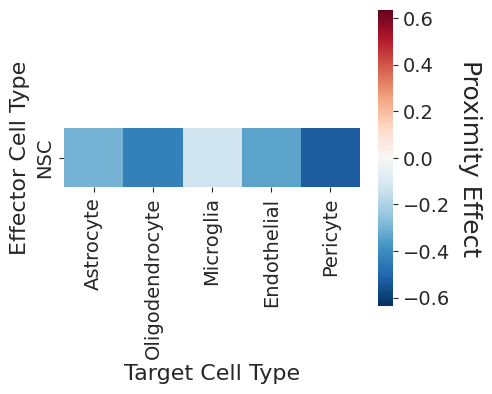

In [11]:
# NSC on within-lineage (Astrocyte, Oligodendrocyte) and
# on outside-lineage (Microglia, Endothelial, Pericyte)

effector_cells = ["NSC"]
receiver_cells = ["Astrocyte", "Oligodendrocyte",
                  "Microglia", "Endothelial", "Pericyte"]

###########################################################
sub_cond_df = comb_df[comb_df['Near Cell'].isin(effector_cells)]
sub_cond_df = sub_cond_df[sub_cond_df['AgeAccel Cell'].isin(receiver_cells)]
sub_cond_df["Near Cell"] = sub_cond_df["Near Cell"].astype('category').cat.reorder_categories([x for x in effector_cells if x in sub_cond_df['Near Cell'].values])
sub_cond_df["AgeAccel Cell"] = sub_cond_df["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in receiver_cells if x in sub_cond_df['AgeAccel Cell'].values])

pivot_df = sub_cond_df.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")


fig, ax = plt.subplots(figsize=(5,4))
# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 16, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.max(np.abs(sub_cond_df["Aging Effect"]))*1.2,
            vmax=np.max(np.abs(sub_cond_df["Aging Effect"]))*1.2)

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Target Cell Type", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"plots/proximity/celltype_proximity_age_accel_ttest_heatmap_NSClineage.pdf",
           bbox_inches='tight')
plt.show()

### Average Proximity Effect by effector cell type

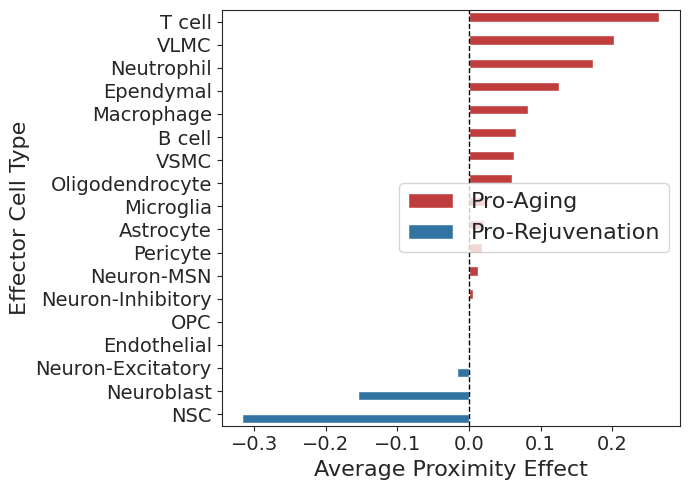

In [16]:
# subset to only restricted cells among target cell types
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()

# compute average proximity effects for each effector cell and then rank order
celltypes = []
average_effects = []
colors = []

for ct in np.unique(comb_df_sub["Near Cell"]):
    average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd.pdf",
            bbox_inches='tight')
plt.show()


# save results for later plots
save_df = pd.DataFrame([])
save_df["celltype"] = celltypes
save_df["avg_prox_eff"] = average_effects
save_df.to_csv("results/proximity/average_proximity_effect_main.csv", index=False)

### Most impacted target cell types

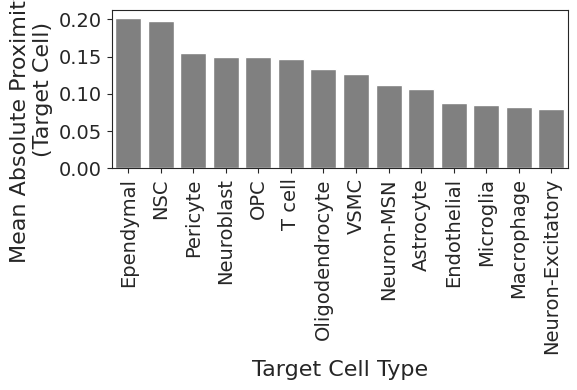

In [21]:
# restrict to target cell types in restricted subset
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()

# compute mean absolute proximity effect experienced by each target cell type
celltypes = []
average_effects = []

for ct in restricted_celltype_subset:
    average_effect = np.nanmean(np.abs(comb_df_sub[comb_df_sub["AgeAccel Cell"]==ct]["Aging Effect"]))
    celltypes.append(ct)
    average_effects.append(average_effect)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]

# make plot of ranked experienced mean absolute proximity effects
plt.figure(figsize=(6,4))

g = sns.barplot(
    x=celltypes,
    y=average_effects,
    color='0.5',
)

plt.xlabel("Target Cell Type", fontsize=16)
plt.ylabel("Mean Absolute Proximity Effect\n(Target Cell)", fontsize=16)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_impact_AVG_verbar_cohensd.pdf",
            bbox_inches='tight')
plt.show()

## Region-specific proximity effects

General takeaway here is that within each region, there aren't generally sufficient numbers of cells to fully resolve the proximity effects to the same level as the global and pooled analysis.

In [7]:
# define coarse regions
coarse_region_mapping = {
    "CC/ACO":"CC/ACO",
    "CTX_L1/MEN":"CTX",
    "CTX_L2/3":"CTX",
    "CTX_L4/5/6":"CTX",
    "STR_CP/ACB":"STR",
    "STR_LS/NDB":"STR",
    "VEN":"VEN",
}

adata.obs["region_coarse"] = [coarse_region_mapping[x] for x in adata.obs.region]

In [ ]:
celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                'Ependymal', 'Neuroblast', 'NSC', 
                'Macrophage', 'Neutrophil','T cell', 'B cell']


for celltype in celltypes:
    
    comb_df = pd.DataFrame([])

    for region in np.unique(adata.obs.region_coarse):

        # Subset by region
        region_adata = adata[adata.obs.region_coarse==region].copy()

        # Make proximity stats
        cutoff_multiplier = 1

        ###########################

        for ct in pd.unique(region_adata.obs.celltype).sort_values():

            sub_adata = region_adata[region_adata.obs["celltype"]==ct]

            # get paired proximity sets
            near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)

            # run test
            df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
            df["Near Cell"] = [f"{x} ({region})" for x in df["Near Cell"].values]

            comb_df = pd.concat((comb_df, df))

    # Make Heatmap plot
    comb_df_sub = comb_df
    comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)]
    comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in comb_df_sub['AgeAccel Cell'].values])


    pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

    fig, ax = plt.subplots(figsize=(9,10))

    # set X mask for NaN values
    sns.heatmap(
        np.where(pivot_df.isna(), 0, np.nan),
        square=True,
        cbar=False,
        annot=np.full_like(pivot_df, "X", dtype=object),
        fmt="",
        annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
        cmap=ListedColormap(['none']),
        linewidth=0, ax=ax)

    # make colored heatmap
    sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
                vmin=-np.max(np.abs(comb_df_sub["Aging Effect"])),
                vmax=np.max(np.abs(comb_df_sub["Aging Effect"])),
                cbar_kws={"shrink": 0.3})

    ax.collections[1].colorbar.set_label('Proximity Effect',
                                        rotation=270, fontsize=18, labelpad=23)
    ax.collections[1].colorbar.ax.tick_params(labelsize=14)

    plt.ylabel("Effector Cell Type", fontsize=18)
    plt.xlabel("Target Cell Type", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.savefig(f"plots/proximity/celltype_proximity_age_accel_ttest_heatmap_RegionalCoarse{celltype}_spatialsmooth_regionmatchedfarthest_cohensd.pdf",
               bbox_inches='tight')
    plt.show()

# Proximity with VLMC-lesion brains removed

This is a sanity check for the high pro-aging proximity effect of VLMCs. We noticed that some sections have lesions with borders defined by densely populated VLMCs. If we remove those sections and redo the proximity effect analysis, the VLMC pro-aging proximity effect is significantly reduced (still pro-aging but much less than before where it was second only to T cells). T cells are still the most pro-aging.

In [13]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

In [14]:
# remove VLMC lesion outlier
print(adata.shape)
adata = adata[(adata.obs.age!=4.3)&(adata.obs.age!=32.6)].copy()
print(adata.shape)

(1453144, 300)
(1290679, 300)


In [15]:
get_age_acceleration (adata)

In [16]:
# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

In [17]:
# Compute proximity stats

cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']
###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))

/local/scratch/edsun/slrmtmp.41937049/ipykernel_37844/2345233496.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")


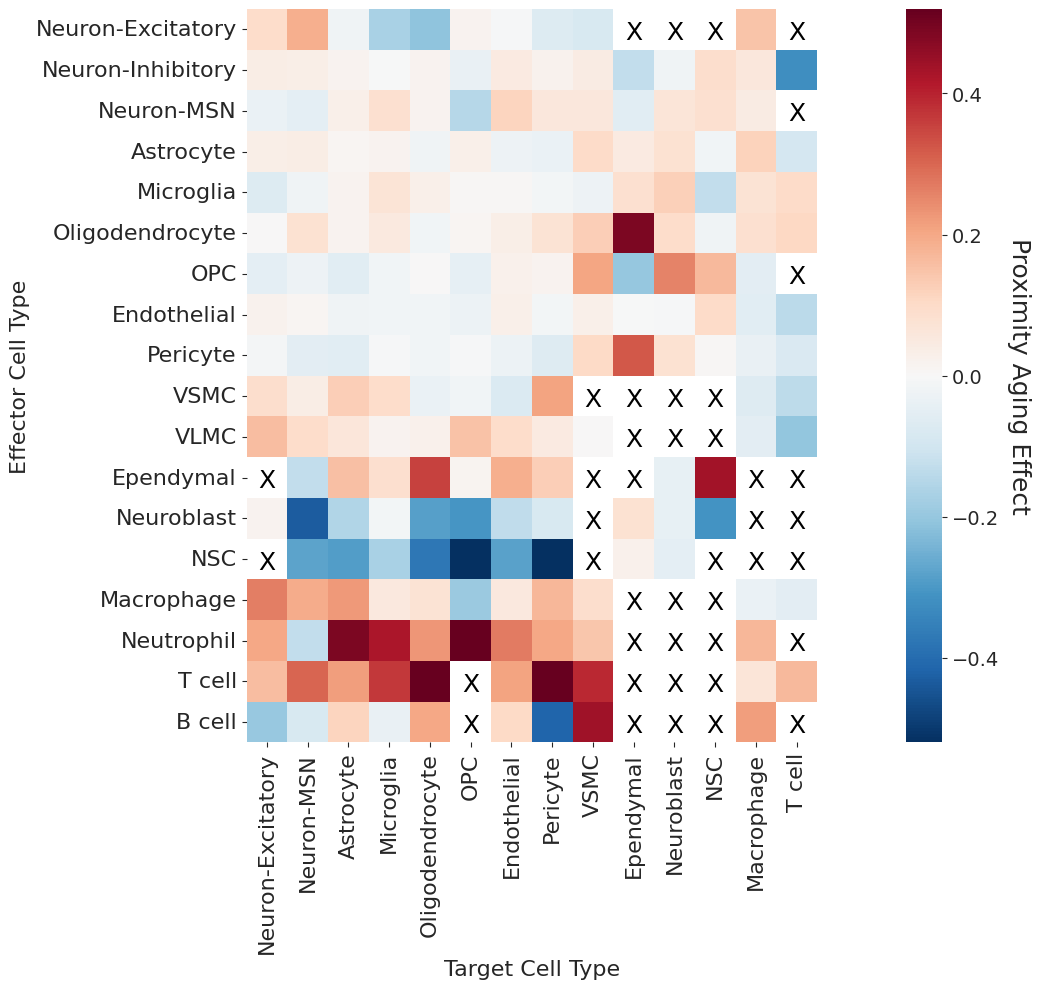

In [18]:
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
comb_df_sub["Near Cell"] = comb_df_sub["Near Cell"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in comb_df_sub['Near Cell'].values])
comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in comb_df_sub['AgeAccel Cell'].values])

pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

#fig, ax = plt.subplots(figsize=(9,5))
fig, ax = plt.subplots(figsize=(18,10))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98),
            vmax=np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98))

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Target Cell Type", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/proximity/VLMCLesionRemoved_celltype_proximity_age_accel_ttest_heatmap_ALL_spatialsmooth_regionmatchedfarthest_cohensd.pdf",
          bbox_inches='tight')
plt.show()

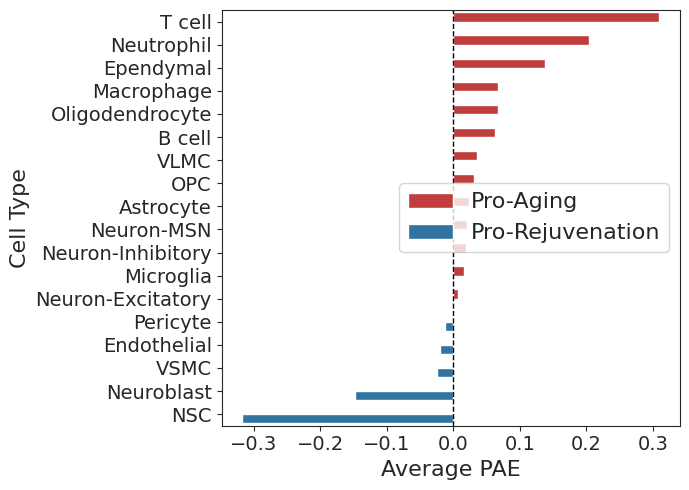

In [19]:
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()


celltypes = []
average_effects = []
colors = []

for ct in np.unique(comb_df_sub["Near Cell"]):
    average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

plt.figure(figsize=(7,5))

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/VLMCLesionRemoved_celltype_proximity_age_accel_AVG_horbar_cohensd.pdf",
            bbox_inches='tight')
plt.show()

# Spatial permutation control for proximity effects

Here we randomly permuted cell type labels across the dataset to control for cell type proportions, regional differences, or changes with age in these features.

In [7]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

In [24]:
# RUN THIS FOR GLOBAL PERMUTATION
# global permutation

for mid in np.unique(adata.obs.mouse_id):
    spatial_coords = np.array(adata.obsm["spatial"][adata.obs.mouse_id==mid,:]).copy()
    np.random.seed(444)
    permuted_idxs = np.random.permutation(np.arange(spatial_coords.shape[0]))
    adata.obsm["spatial"][adata.obs.mouse_id==mid,:] = spatial_coords[permuted_idxs,:]

In [21]:
# RUN THIS INSTEAD FOR SUBREGIONAL PERMUTATION (used in paper)
# subregional permutation
spatial_coords = np.array(adata.obsm["spatial"]).copy()
for mid in np.unique(adata.obs.mouse_id):
    for subreg in np.unique(adata.obs.region):
        np.random.seed(444)
        permuted_idxs = np.random.permutation(np.array((adata.obs.mouse_id==mid)&(adata.obs.region==subreg)).nonzero()[0])
        adata.obsm["spatial"][(adata.obs.mouse_id==mid)&(adata.obs.region==subreg),:] = spatial_coords[permuted_idxs,:]

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


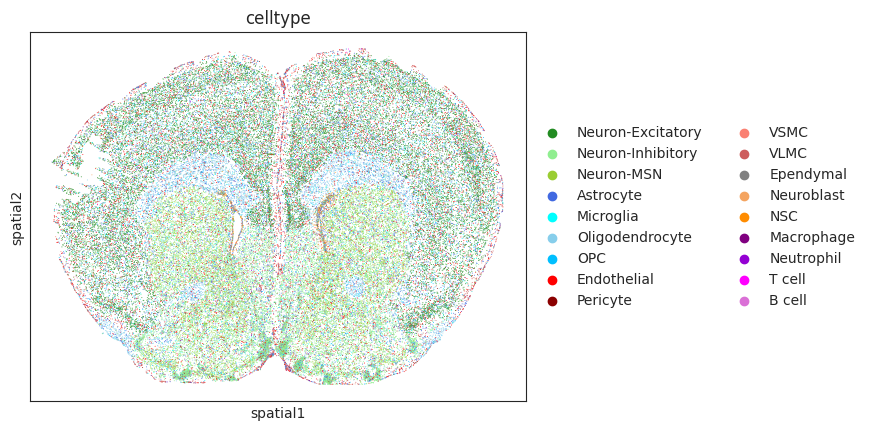

In [22]:
# check permutation visually
sc.pl.embedding(adata[adata.obs.mouse_id=="11"],"spatial",color="celltype")

## Multiple permutations and combined plot with main proximity effects

In [ ]:
# global permutation multiple times

n_permutations = 20


# ----------------------------------------------------------------

np.random.seed(444)
random_seeds = np.random.randint(0,50000,size=n_permutations)

# iterate seeds for permutation
for seed in random_seeds:
    
    # read fresh data
    adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")
    
    # permute cells in each sample
    for mid in np.unique(adata.obs.mouse_id):
        spatial_coords = np.array(adata.obsm["spatial"][adata.obs.mouse_id==mid,:]).copy()
        np.random.seed(seed)
        permuted_idxs = np.random.permutation(np.arange(spatial_coords.shape[0]))
        adata.obsm["spatial"][adata.obs.mouse_id==mid,:] = spatial_coords[permuted_idxs,:]
        
    # get age acceleration
    get_age_acceleration (adata)
    
    # Compute nearest to cell type distances
    nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")
    
    # Compute proximity stats
    cutoff_multiplier = 1
    celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                        'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                        'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                        'Ependymal', 'Neuroblast', 'NSC', 
                        'Macrophage', 'Neutrophil','T cell', 'B cell']
    ###########################
    comb_df = pd.DataFrame([])
    for celltype in celltypes:
        for ct in pd.unique(adata.obs.celltype).sort_values():
            sub_adata = adata[adata.obs["celltype"]==ct]
            # get paired proximity sets
            near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
            # run test
            df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
            comb_df = pd.concat((comb_df, df))
            
    # get average proximity effects
    comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
    
    celltypes = []
    average_effects = []

    for ct in np.unique(comb_df_sub["Near Cell"]):
        average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
        celltypes.append(ct)
        average_effects.append(average_effect)
    
    # save results for later plots
    save_df = pd.DataFrame([])
    save_df["celltype"] = celltypes
    save_df["avg_prox_eff"] = average_effects
    save_df.to_csv(f"results/proximity/global_permuted/average_proximity_effect_{seed}.csv", index=False)

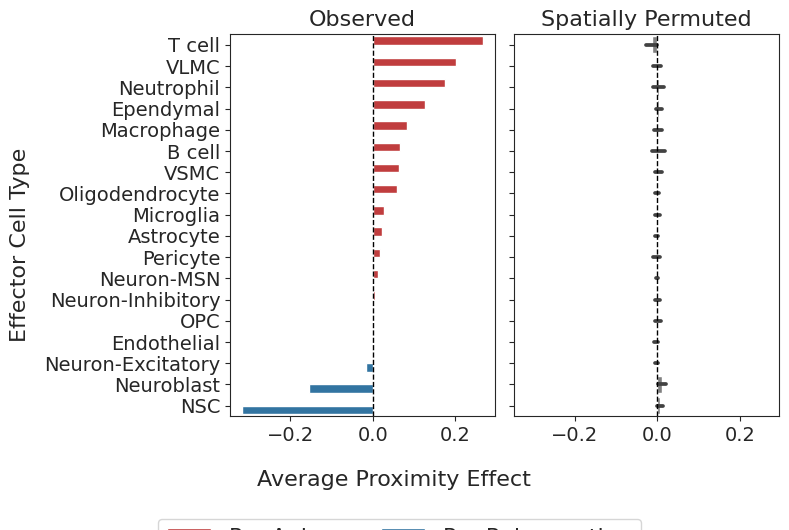

In [24]:
# visualize results

# read main results
main_df = pd.read_csv(f"results/proximity/average_proximity_effect_main.csv")
celltypes = main_df["celltype"].values
avg_prox_effs = main_df["avg_prox_eff"].values

# get main colors
colors_main = []
for average_effect in avg_prox_effs:
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    colors_main.append(color)

# read permuted results and compile
ape_dict = {}

files = os.listdir("results/proximity/global_permuted")

for fn in files:
    if "main" not in fn:
        perm_df = pd.read_csv(os.path.join("results/proximity/global_permuted",fn))
        perm_celltypes = perm_df["celltype"].values
        perm_avg_prox_effs = perm_df["avg_prox_eff"].values
        for ci, ct in enumerate(perm_celltypes):
            if ct not in ape_dict.keys():
                ape_dict[ct] = [perm_avg_prox_effs[ci]]
            else:
                ape_dict[ct].append(perm_avg_prox_effs[ci])
            
# get permutation statistics
permuted_apes = []
permuted_celltypes = []
permuted_ape_median = []
for ct in celltypes:
    permuted_apes += ape_dict[ct]
    permuted_celltypes += [ct]*len(ape_dict[ct])
    permuted_ape_median.append(np.median(ape_dict[ct]))
permuted_results_df = pd.DataFrame([])
permuted_results_df["celltype"] = permuted_celltypes
permuted_results_df["avg_prox_eff"] = permuted_apes
permuted_results_df["celltype"] = permuted_results_df["celltype"].astype('category').cat.reorder_categories(celltypes)
    
# get permutation colors
colors_permuted = []
for average_effect in permuted_ape_median:
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    colors_permuted.append(color)
    
#---------------------------
# Make Figure
#---------------------------

palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

fig, axarr = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(8,5))

# Main
sns.barplot(
    x=avg_prox_effs,
    y=celltypes,
    hue=colors_main,
    palette=palette,
    ax = axarr[0],
)
axarr[0].axvline(0, color='k', linewidth=1, linestyle="--")
#axarr[0].set_xlim(-0.27,0.27)
axarr[0].set_title("Observed", fontsize=16)
axarr[0].legend_.remove()

# Permuted
sns.barplot(
    permuted_results_df,
    x = "avg_prox_eff",
    y = "celltype",
    color = '0.5',
    ax = axarr[1]
)
axarr[1].axvline(0, color='k', linewidth=1, linestyle="--")
#axarr[1].set_xlim(-0.27,0.27)
axarr[1].set_title("Spatially Permuted", fontsize=16)
axarr[1].set_xlabel("")
axarr[1].set_ylabel("")

# set tick params
for a in axarr.flatten():
    a.tick_params(axis='both', which='major', labelsize=14)
    a.tick_params(axis='both', which='minor', labelsize=14)

# axis labels 
fig.supxlabel("Average Proximity Effect", fontsize=16)
fig.supylabel("Effector Cell Type", fontsize=16)

# legend
lines_labels = [[ax.get_legend_handles_labels() for ax in fig.axes][0]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.2, -0.05), ncol=2, fontsize=16)

# save and show
plt.tight_layout()
plt.savefig("plots/proximity/GlobalAndPermuted_celltype_proximity_age_accel_AVG_horbar_cohensd.pdf",
            bbox_inches='tight')
plt.show()

In [ ]:
# subregional permutation multiple times

n_permutations = 20


# ----------------------------------------------------------------

np.random.seed(444)
random_seeds = np.random.randint(0,50000,size=n_permutations)

# iterate seeds for permutation
for seed in random_seeds:
    
    # read fresh data
    adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")
      
    # permute cells in each sample (subregional permutation)
    spatial_coords = np.array(adata.obsm["spatial"]).copy()
    for mid in np.unique(adata.obs.mouse_id):
        for subreg in np.unique(adata.obs.region):
            np.random.seed(seed)
            permuted_idxs = np.random.permutation(np.array((adata.obs.mouse_id==mid)&(adata.obs.region==subreg)).nonzero()[0])
            adata.obsm["spatial"][(adata.obs.mouse_id==mid)&(adata.obs.region==subreg),:] = spatial_coords[permuted_idxs,:]
    
    # get age acceleration
    get_age_acceleration (adata)
    
    # Compute nearest to cell type distances
    nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")
    
    # Compute proximity stats
    cutoff_multiplier = 1
    celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                        'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                        'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                        'Ependymal', 'Neuroblast', 'NSC', 
                        'Macrophage', 'Neutrophil','T cell', 'B cell']
    ###########################
    comb_df = pd.DataFrame([])
    for celltype in celltypes:
        for ct in pd.unique(adata.obs.celltype).sort_values():
            sub_adata = adata[adata.obs["celltype"]==ct]
            # get paired proximity sets
            near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
            # run test
            df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
            comb_df = pd.concat((comb_df, df))
            
    # get average proximity effects
    comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
    
    celltypes = []
    average_effects = []

    for ct in np.unique(comb_df_sub["Near Cell"]):
        average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
        celltypes.append(ct)
        average_effects.append(average_effect)
    
    # save results for later plots
    save_df = pd.DataFrame([])
    save_df["celltype"] = celltypes
    save_df["avg_prox_eff"] = average_effects
    save_df.to_csv(f"results/proximity/subregion_permuted/average_proximity_effect_subregional{seed}.csv", index=False)

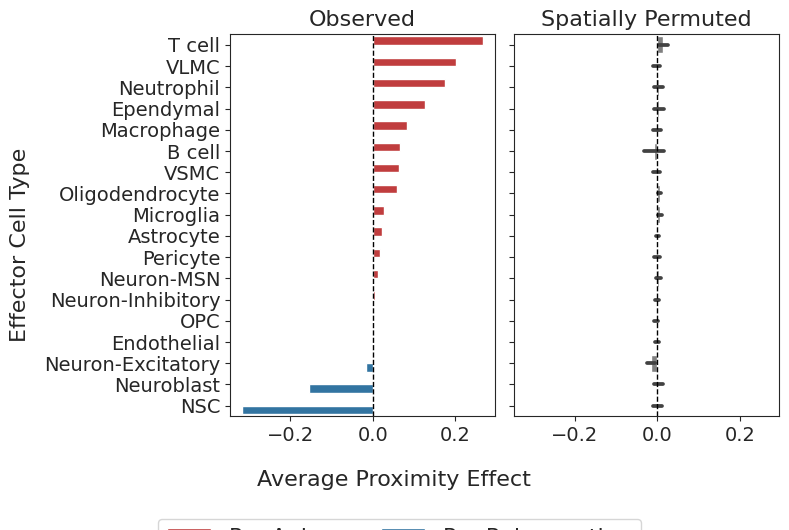

In [5]:
# visualize results

# read main results
main_df = pd.read_csv(f"results/proximity/average_proximity_effect_main.csv")
celltypes = main_df["celltype"].values
avg_prox_effs = main_df["avg_prox_eff"].values

# get main colors
colors_main = []
for average_effect in avg_prox_effs:
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    colors_main.append(color)

# read permuted results and compile
ape_dict = {}

files = os.listdir("results/proximity/subregion_permuted")

for fn in files:
    if "main" not in fn:
        perm_df = pd.read_csv(os.path.join("results/proximity/subregion_permuted",fn))
        perm_celltypes = perm_df["celltype"].values
        perm_avg_prox_effs = perm_df["avg_prox_eff"].values
        for ci, ct in enumerate(perm_celltypes):
            if ct not in ape_dict.keys():
                ape_dict[ct] = [perm_avg_prox_effs[ci]]
            else:
                ape_dict[ct].append(perm_avg_prox_effs[ci])
            
# get permutation statistics
permuted_apes = []
permuted_celltypes = []
permuted_ape_median = []
for ct in celltypes:
    permuted_apes += ape_dict[ct]
    permuted_celltypes += [ct]*len(ape_dict[ct])
    permuted_ape_median.append(np.median(ape_dict[ct]))
permuted_results_df = pd.DataFrame([])
permuted_results_df["celltype"] = permuted_celltypes
permuted_results_df["avg_prox_eff"] = permuted_apes
permuted_results_df["celltype"] = permuted_results_df["celltype"].astype('category').cat.reorder_categories(celltypes)
    
# get permutation colors
colors_permuted = []
for average_effect in permuted_ape_median:
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    colors_permuted.append(color)
    
#---------------------------
# Make Figure
#---------------------------

palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

fig, axarr = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(8,5))

# Main
sns.barplot(
    x=avg_prox_effs,
    y=celltypes,
    hue=colors_main,
    palette=palette,
    ax = axarr[0],
)
axarr[0].axvline(0, color='k', linewidth=1, linestyle="--")
#axarr[0].set_xlim(-0.27,0.27)
axarr[0].set_title("Observed", fontsize=16)
axarr[0].legend_.remove()

# Permuted
sns.barplot(
    permuted_results_df,
    x = "avg_prox_eff",
    y = "celltype",
    color = '0.5',
    ax = axarr[1]
)
axarr[1].axvline(0, color='k', linewidth=1, linestyle="--")
#axarr[1].set_xlim(-0.27,0.27)
axarr[1].set_title("Spatially Permuted", fontsize=16)
axarr[1].set_xlabel("")
axarr[1].set_ylabel("")

# set tick params
for a in axarr.flatten():
    a.tick_params(axis='both', which='major', labelsize=14)
    a.tick_params(axis='both', which='minor', labelsize=14)

# axis labels 
fig.supxlabel("Average Proximity Effect", fontsize=16)
fig.supylabel("Effector Cell Type", fontsize=16)

# legend
lines_labels = [[ax.get_legend_handles_labels() for ax in fig.axes][0]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.2, -0.05), ncol=2, fontsize=16)

# save and show
plt.tight_layout()
plt.savefig("plots/proximity/SubregionalAndPermuted_celltype_proximity_age_accel_AVG_horbar_cohensd.pdf",
            bbox_inches='tight')
plt.show()

## Heatmap of AgeAccel interactions split by Young and Old

### Younger animals analysis (<16 months)

In [14]:
# subset to younger animals (<16 months)
young_adata = adata[adata.obs.age < 16]

In [ ]:
# Dot Plot of Age acceleration

cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(young_adata.obs.celltype).sort_values():
        
        sub_adata = young_adata[young_adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, young_adata)
        
        comb_df = pd.concat((comb_df, df))

In [ ]:
comb_df_sub_young = comb_df_sub.copy() # Copies object for later combined analysis

### Older animals analysis (>16 months)

In [18]:
# subset to older animals (>16 months)
old_adata = adata[adata.obs.age > 16]

In [ ]:
cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(old_adata.obs.celltype).sort_values():
        
        sub_adata = old_adata[old_adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, old_adata)
        
        comb_df = pd.concat((comb_df, df))

In [ ]:
comb_df_sub_old = comb_df_sub.copy() # Copies object for later combined analysis

### Combined heatmap with Younger and Older groups

In [22]:
# combine heatmap objects from younger and older analysis

comb_df_sub_young["Near Cell"] = [idx+" (Young)" for idx in comb_df_sub_young["Near Cell"]]
comb_df_sub_old["Near Cell"] = [idx+" (Old)" for idx in comb_df_sub_old["Near Cell"]]

comb_df_sub_combined = pd.concat((comb_df_sub_young,comb_df_sub_old))

/local/scratch/edsun/slrmtmp.42174461/ipykernel_38300/548375606.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = comb_df_sub_combined.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")


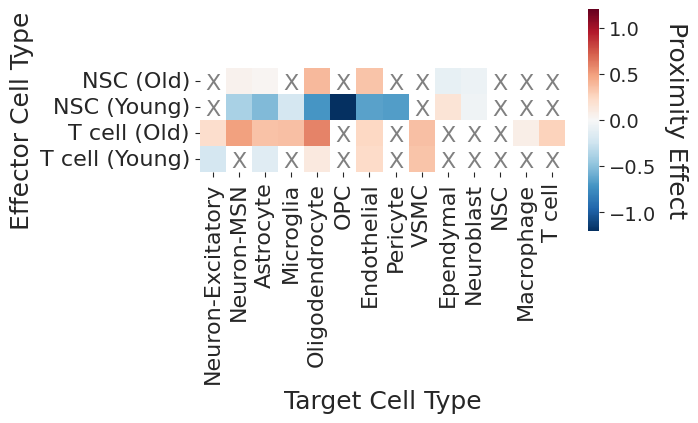

In [23]:
# Heatmap for proximity effects in younger/older T cells and NSCs

pivot_df = comb_df_sub_combined.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

fig, ax = plt.subplots(figsize=(7,4))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 16, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-1.2,
            vmax=1.2)

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)


plt.ylabel("Effector Cell Type", fontsize=18)
plt.xlabel("Target Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_ttest_heatmap_COMBINED_spatialsmooth_regionmatchedfarthest_cohensd_RESTRICTED.pdf",
           bbox_inches='tight')
plt.show()

### Combined barplot for frequency of proximity interactions in younger/older groups

In [24]:
# combine results from younger and older

comb_df_sub_young["Near Cell"] = [idx.split(" (")[0] for idx in comb_df_sub_young["Near Cell"]]
comb_df_sub_old["Near Cell"] = [idx.split(" (")[0] for idx in comb_df_sub_old["Near Cell"]]

comb_df_sub_young["Age Group"] = "Young"
comb_df_sub_old["Age Group"] = "Old"

comb_df_sub_combined = pd.concat((comb_df_sub_young,comb_df_sub_old))

In [25]:
comb_df_sub_combined_restricted = comb_df_sub_combined[((comb_df_sub_combined["Near Cell"]=="NSC")&(comb_df_sub_combined["AgeAccel Cell"].isin(["OPC","Pericyte"]))) | (comb_df_sub_combined["Near Cell"]=="T cell")&(comb_df_sub_combined["AgeAccel Cell"].isin(["Pericyte","Oligodendrocyte"]))]

In [26]:
comb_df_sub_combined_restricted["Interaction"] = [comb_df_sub_combined_restricted["Near Cell"].values[i]+"\non\n"+comb_df_sub_combined_restricted["AgeAccel Cell"].values[i] for i in range(comb_df_sub_combined_restricted.shape[0])]

/local/scratch/edsun/slrmtmp.42174461/ipykernel_38300/2947608257.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_df_sub_combined_restricted["Interaction"] = [comb_df_sub_combined_restricted["Near Cell"].values[i]+"\non\n"+comb_df_sub_combined_restricted["AgeAccel Cell"].values[i] for i in range(comb_df_sub_combined_restricted.shape[0])]


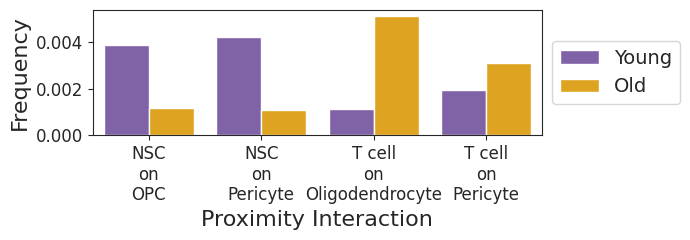

In [27]:
# plot normalized frequency of interactions

palette = {"Young":"#7F57B2",
           "Old":"#FEAF00"}

plt.figure(figsize=(7,2.5))
sns.barplot(comb_df_sub_combined_restricted, x="Interaction", y="Near Freq",
            hue="Age Group", palette=palette)
plt.xlabel("Proximity Interaction", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("plots/proximity/nearfreq_old_young_nsc_tcell.pdf",
           bbox_inches='tight')
plt.show()

## AgeAccel interactions/proximity for T cell subtypes

In [4]:
new_restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

In [6]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

# age accel
get_age_acceleration (adata)

celltype_fineres = adata.obs["celltype"].values.astype(str)

In [7]:
def recluster_subset(sub_adata, resolution=0.1, n_pcs=20, n_neighbors=15):
    '''
    Runs clustering (pca -> neighbors -> leiden + umap) on sub_adata
    '''
    sc.tl.pca(sub_adata)
    sc.pp.neighbors(sub_adata, n_pcs=n_pcs, n_neighbors=n_neighbors)
    sc.tl.umap(sub_adata)
    sc.tl.leiden(sub_adata, key_added="leiden", resolution=resolution)

In [8]:
# recluster T cells
celltype_to_subcluster = "T cell"
sub_adata = adata[adata.obs['celltype']==celltype_to_subcluster]
recluster_subset(sub_adata, resolution=0.5)

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm['X_pca'] = X_pca
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


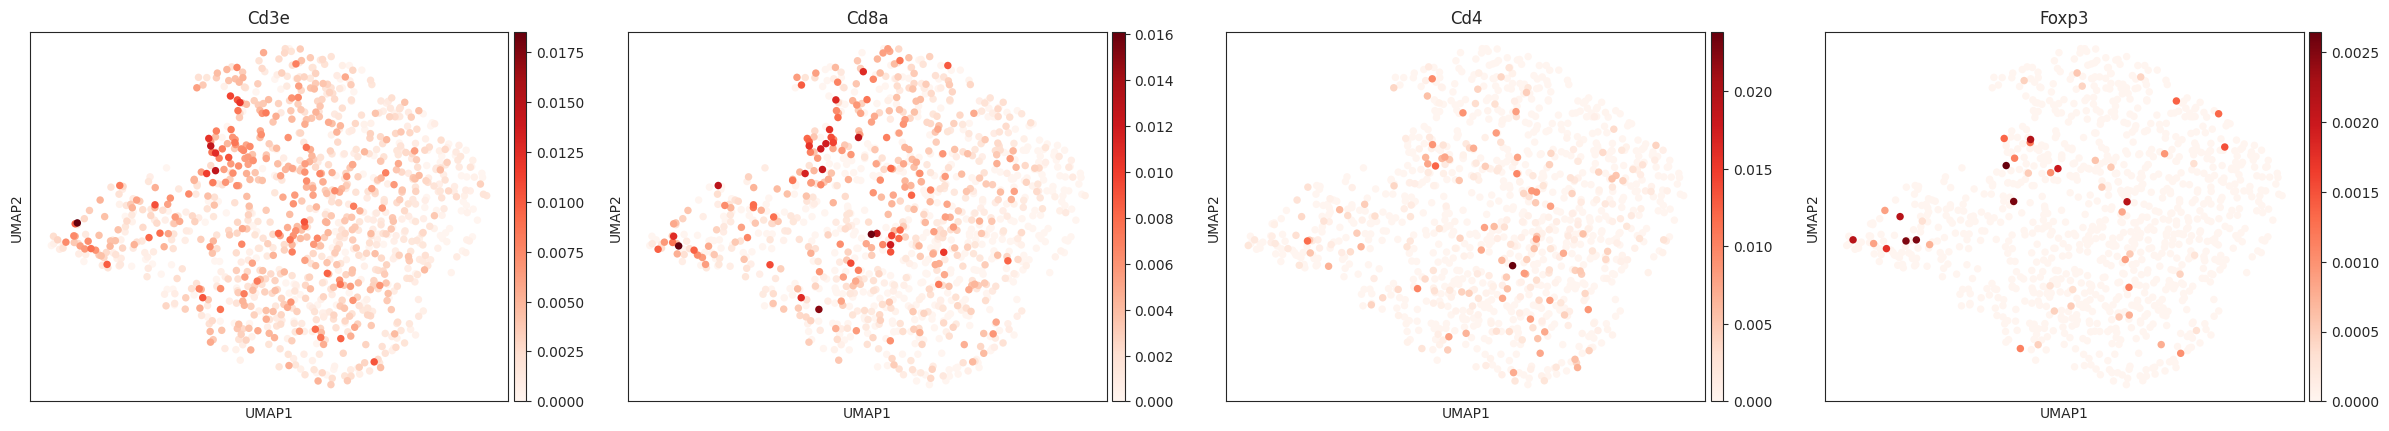

In [13]:
sc.pl.umap(sub_adata, color=["Cd3e","Cd8a","Cd4","Foxp3"], cmap='Reds')
plt.savefig("")

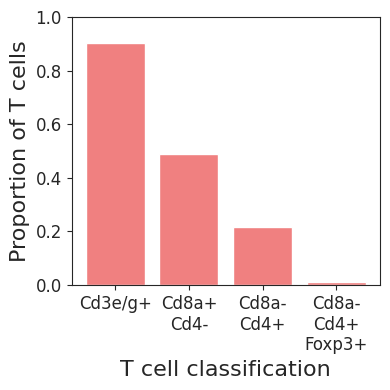

In [28]:
# Plot breakdown of T cells by markers
plt.figure(figsize=(4,4))

plt.bar(["Cd3e/g+","Cd8a+\nCd4-","Cd8a-\nCd4+","Cd8a-\nCd4+\nFoxp3+"],
        [np.sum((sub_adata[:,"Cd3e"].X>0)|(sub_adata[:,"Cd3g"].X>0))/sub_adata.shape[0],
         np.sum((sub_adata[:,"Cd8a"].X>0)&(sub_adata[:,"Cd4"].X<=0))/sub_adata.shape[0],
         np.sum((sub_adata[:,"Cd8a"].X<=0)&(sub_adata[:,"Cd4"].X>0))/sub_adata.shape[0],
         np.sum((sub_adata[:,"Cd8a"].X<=0)&(sub_adata[:,"Cd4"].X>0)&(sub_adata[:,"Foxp3"].X>0))/sub_adata.shape[0]],
        color='lightcoral')
plt.ylim(0,1)
plt.ylabel("Proportion of T cells", fontsize=16)
plt.xlabel("T cell classification", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("plots/proximity/Tcell_subtype_marker_breakdown_barplot.pdf",
           bbox_inches='tight')
plt.show()

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


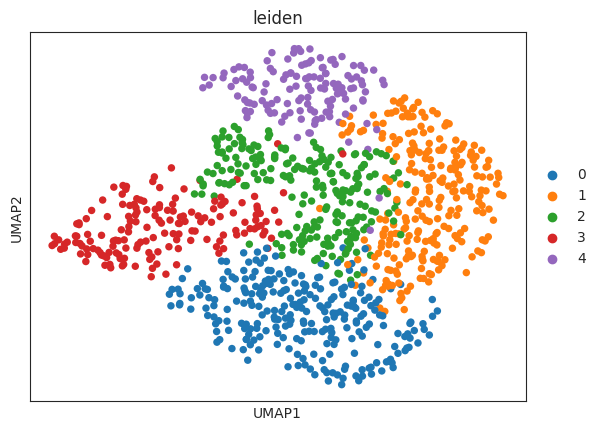

T cell (cytotoxic)


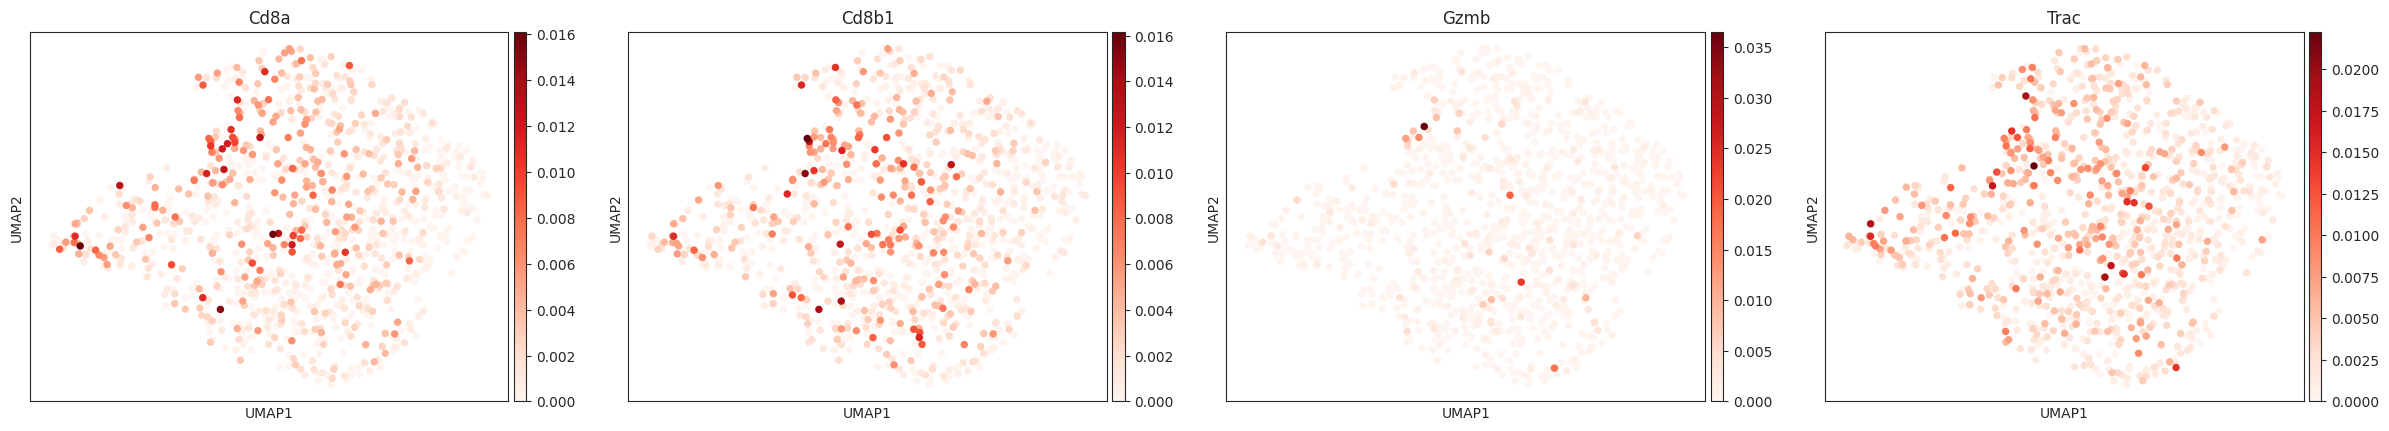

T cell (helper)


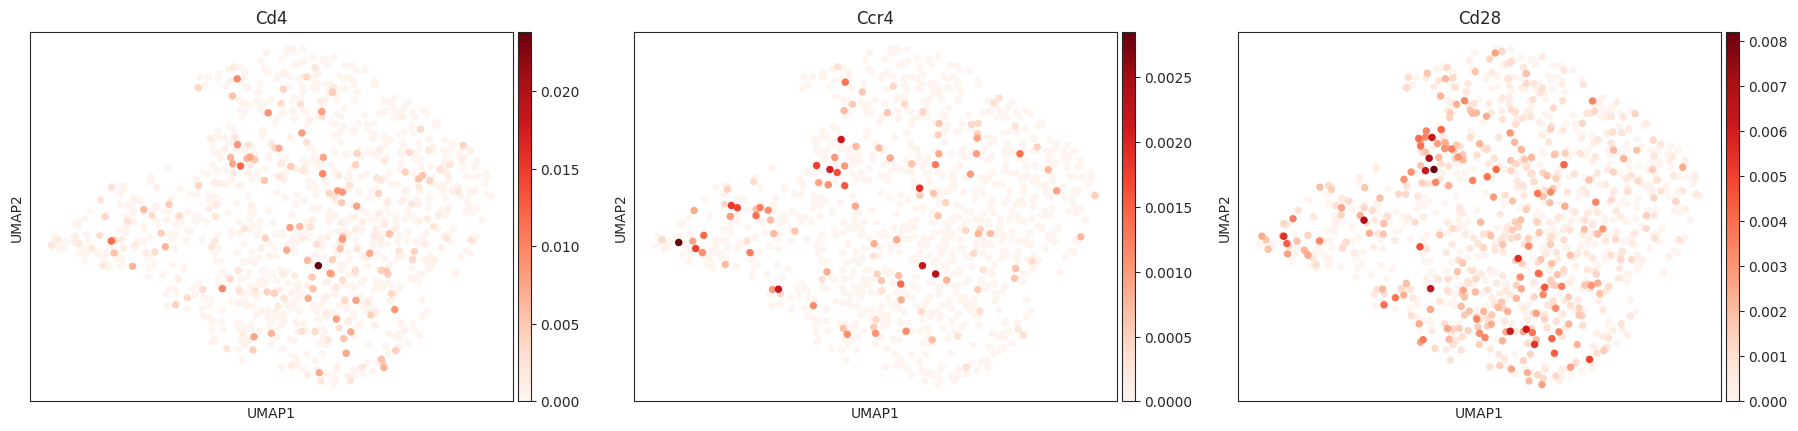

T cell (reg)


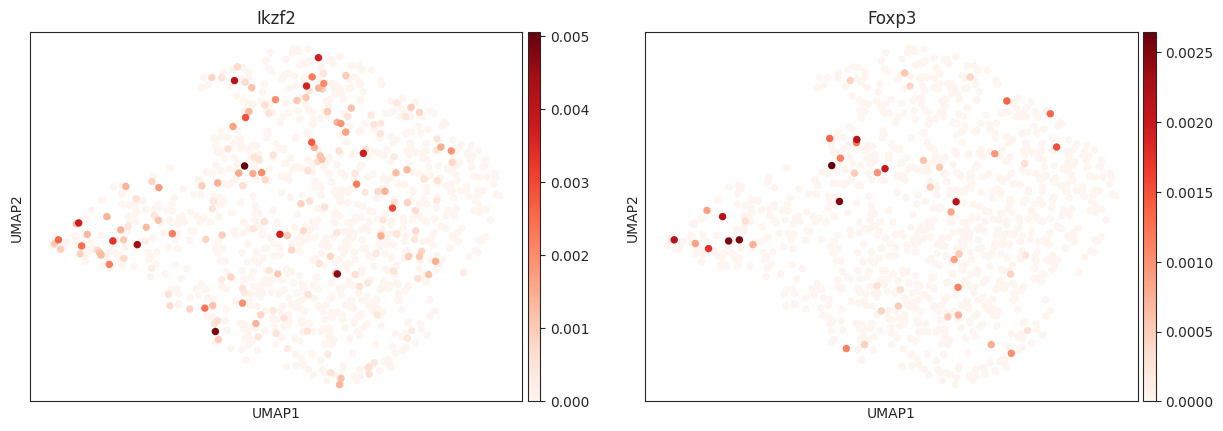

T cell (tissue retention)


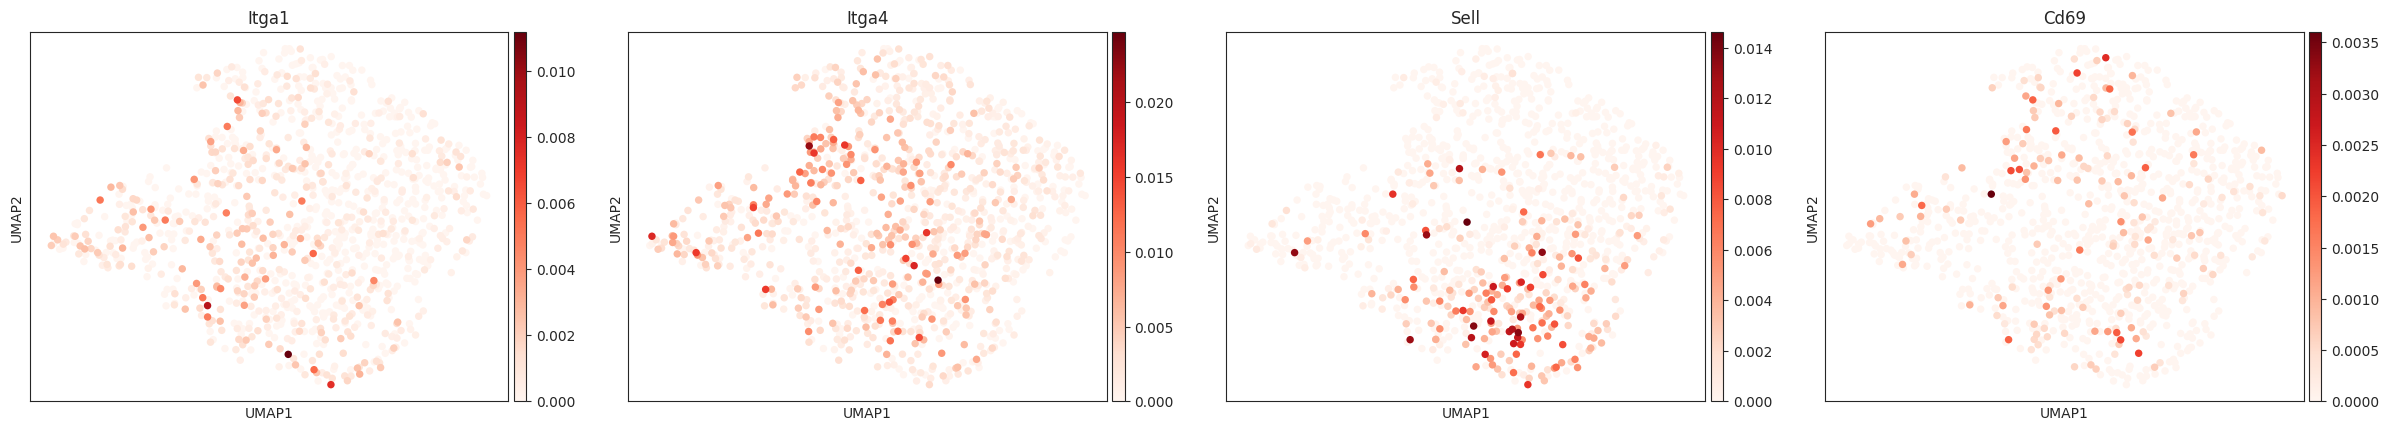

NK cell


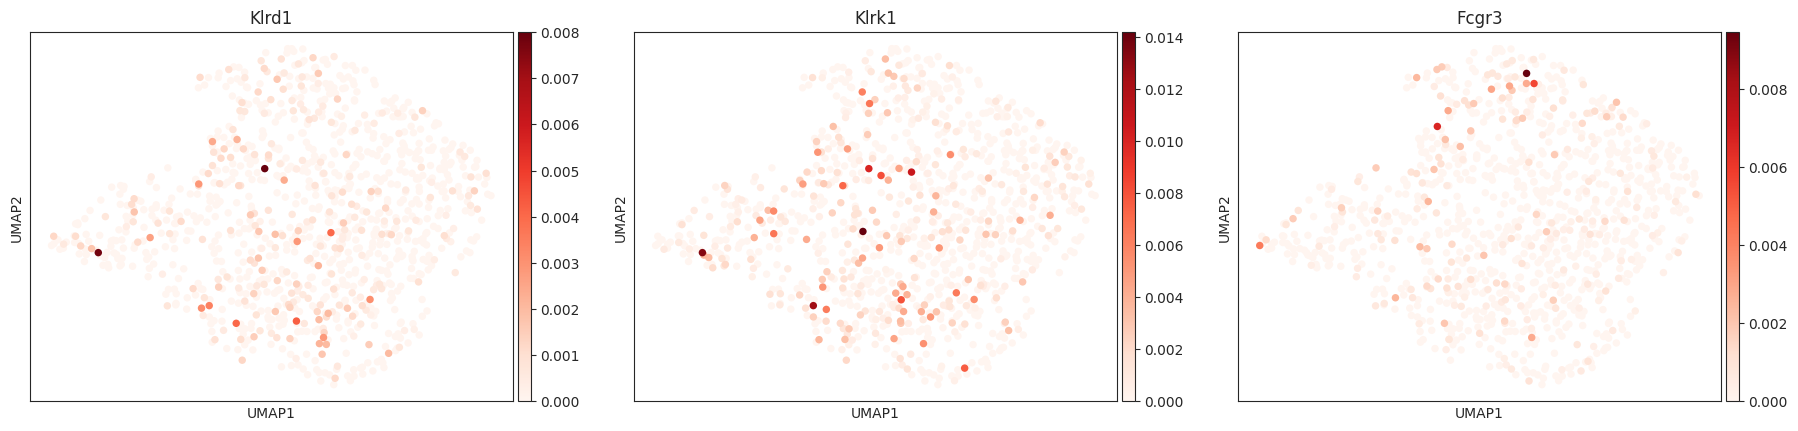

In [8]:
# show markers

major_celltype_markers_dict = {
    "Neuron":["Dpp6", "Reln"],
    "Excitatory Neuron":["Slc17a7", "Slc17a6"],
    "Inhibitory Neuron":["Slc32a1", "Gad1", "Gad2"],
    "MSN":["Drd1", "Drd2", "Adora2a"],
    "Other_Neuron":["Chat","Slc6a3","Th","Tph2"],
    "Astrocyte":["Aqp4", "Gfap", "Aldh1l1"],
    "Microglia":["Cx3cr1", "C1ql3", "Csf1r","Ccl4","C1qa","C1qb","Hexb"],
    "Oligodendrocyte":["Olig1", "Olig2", "Opalin", "Mog", "Klk6", "Cldn11"],
    "OPC":["Pdgfra", "Vcan"],
    "New_Olig":["Gpr17","Bmp4"],
    "Endothelial":["Flt1","Cldn5","Apold1","Ly6c1"],
    "LEC":["Flt4","Prox1","Pecam1","Pdpn"],
    "Hemoglobin-expressing vascular cells":["Alas2"],
    "VSMC":["Acta2"],
    "VLMC":["Slc6a13"],
    "Pericyte":["Kcnj8", "Vtn", "Ifitm1"],
    "Ependymal":["Ccdc153", "Rarres2", "Tmem212"],
    "qNSC":["Prom1", "Slc1a3", "Nr2e1", "Sox9", "Vcam1", "Hes5", "Cd9", "Thbs4", "Gja1"],
    "aNSC/NPC":["Pclaf", "H2afx", "Rrm2", "Insm1", "Egfr", "Mki67", "Mcm2", "Cdk1"],
    "Neuroblast":["Stmn2", "Dlx6os1", "Igfbpl1", "Dcx", "Cd24a", "Tubb3", "Sox11", "Dlx1"],
    "Macrophage":["Mrc1", "Pf4", "Lyz2"],
    "T cell":["Cd3e","Nkg7","Ccl5","Ms4a4b","Cd3g","Cd69","Lat"],
    "T cell (cytotoxic)":["Cd8a","Cd8b1","Gzmb","Trac"],
    "T cell (helper)":["Cd4","Ccr4","Cd28"],
    "T cell (reg)":["Ikzf2","Foxp3"],
    "T cell (tissue retention)":["Itga1","Itga4","Sell","Cd69"],
    "NK cell":["Klrd1","Klrk1","Fcgr3"],
    "B cell":["Cd79a","Cd19","Ighm","Ighd","Cd27"],
    "B cell (memory)":["Cd40"],
    "B cell (effector/plasma)":["Ly6c2","Sdc1","Ms4a1"],
    "Monocyte":["Plac8", "Ly6c1", "Cx3cr1"], # last two are for inflammatory and resident respectively
    "Dendritic cell":["Cd209a", "Flt3"],
    "Neutrophil":["S100a9","Ptprc","Itgam","Cxcr2"],
    "Mast cell":["Hdc", "Cma1"],
    "Dividing":["Top2a","Mki67","Egfr"],
}

sc.pl.umap(sub_adata, color='leiden')
for key in ["T cell (cytotoxic)", "T cell (helper)", "T cell (reg)", "T cell (tissue retention)", "NK cell"]:
    print(key)
    sc.pl.umap(sub_adata, color=major_celltype_markers_dict[key], cmap='Reds')

### Doesn't seem able to separate T cells into subtypes -- no subtype proximity effect analysis

## AgeAccel interactions/proximity for quiescent vs activated neural stem cells

In [4]:
new_restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','qNSC','aNSC','Macrophage', 'T cell']

In [5]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

# age accel
get_age_acceleration (adata)

celltype_fineres = adata.obs["celltype"].values.astype(str)

In [6]:
def recluster_subset(sub_adata, resolution=0.1, n_pcs=20, n_neighbors=15):
    '''
    Runs clustering (pca -> neighbors -> leiden + umap) on sub_adata
    '''
    sc.tl.pca(sub_adata)
    sc.pp.neighbors(sub_adata, n_pcs=n_pcs, n_neighbors=n_neighbors)
    sc.tl.umap(sub_adata)
    sc.tl.leiden(sub_adata, key_added="leiden", resolution=resolution)

In [7]:
# recluster and split NSCs into qNSCs and aNSCs
celltype_to_subcluster = "NSC"
sub_adata = adata[adata.obs['celltype']==celltype_to_subcluster]
recluster_subset(sub_adata, resolution=0.5)

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm['X_pca'] = X_pca
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


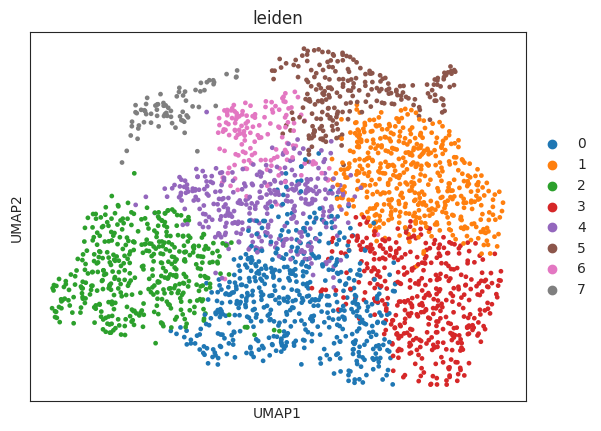

qNSC


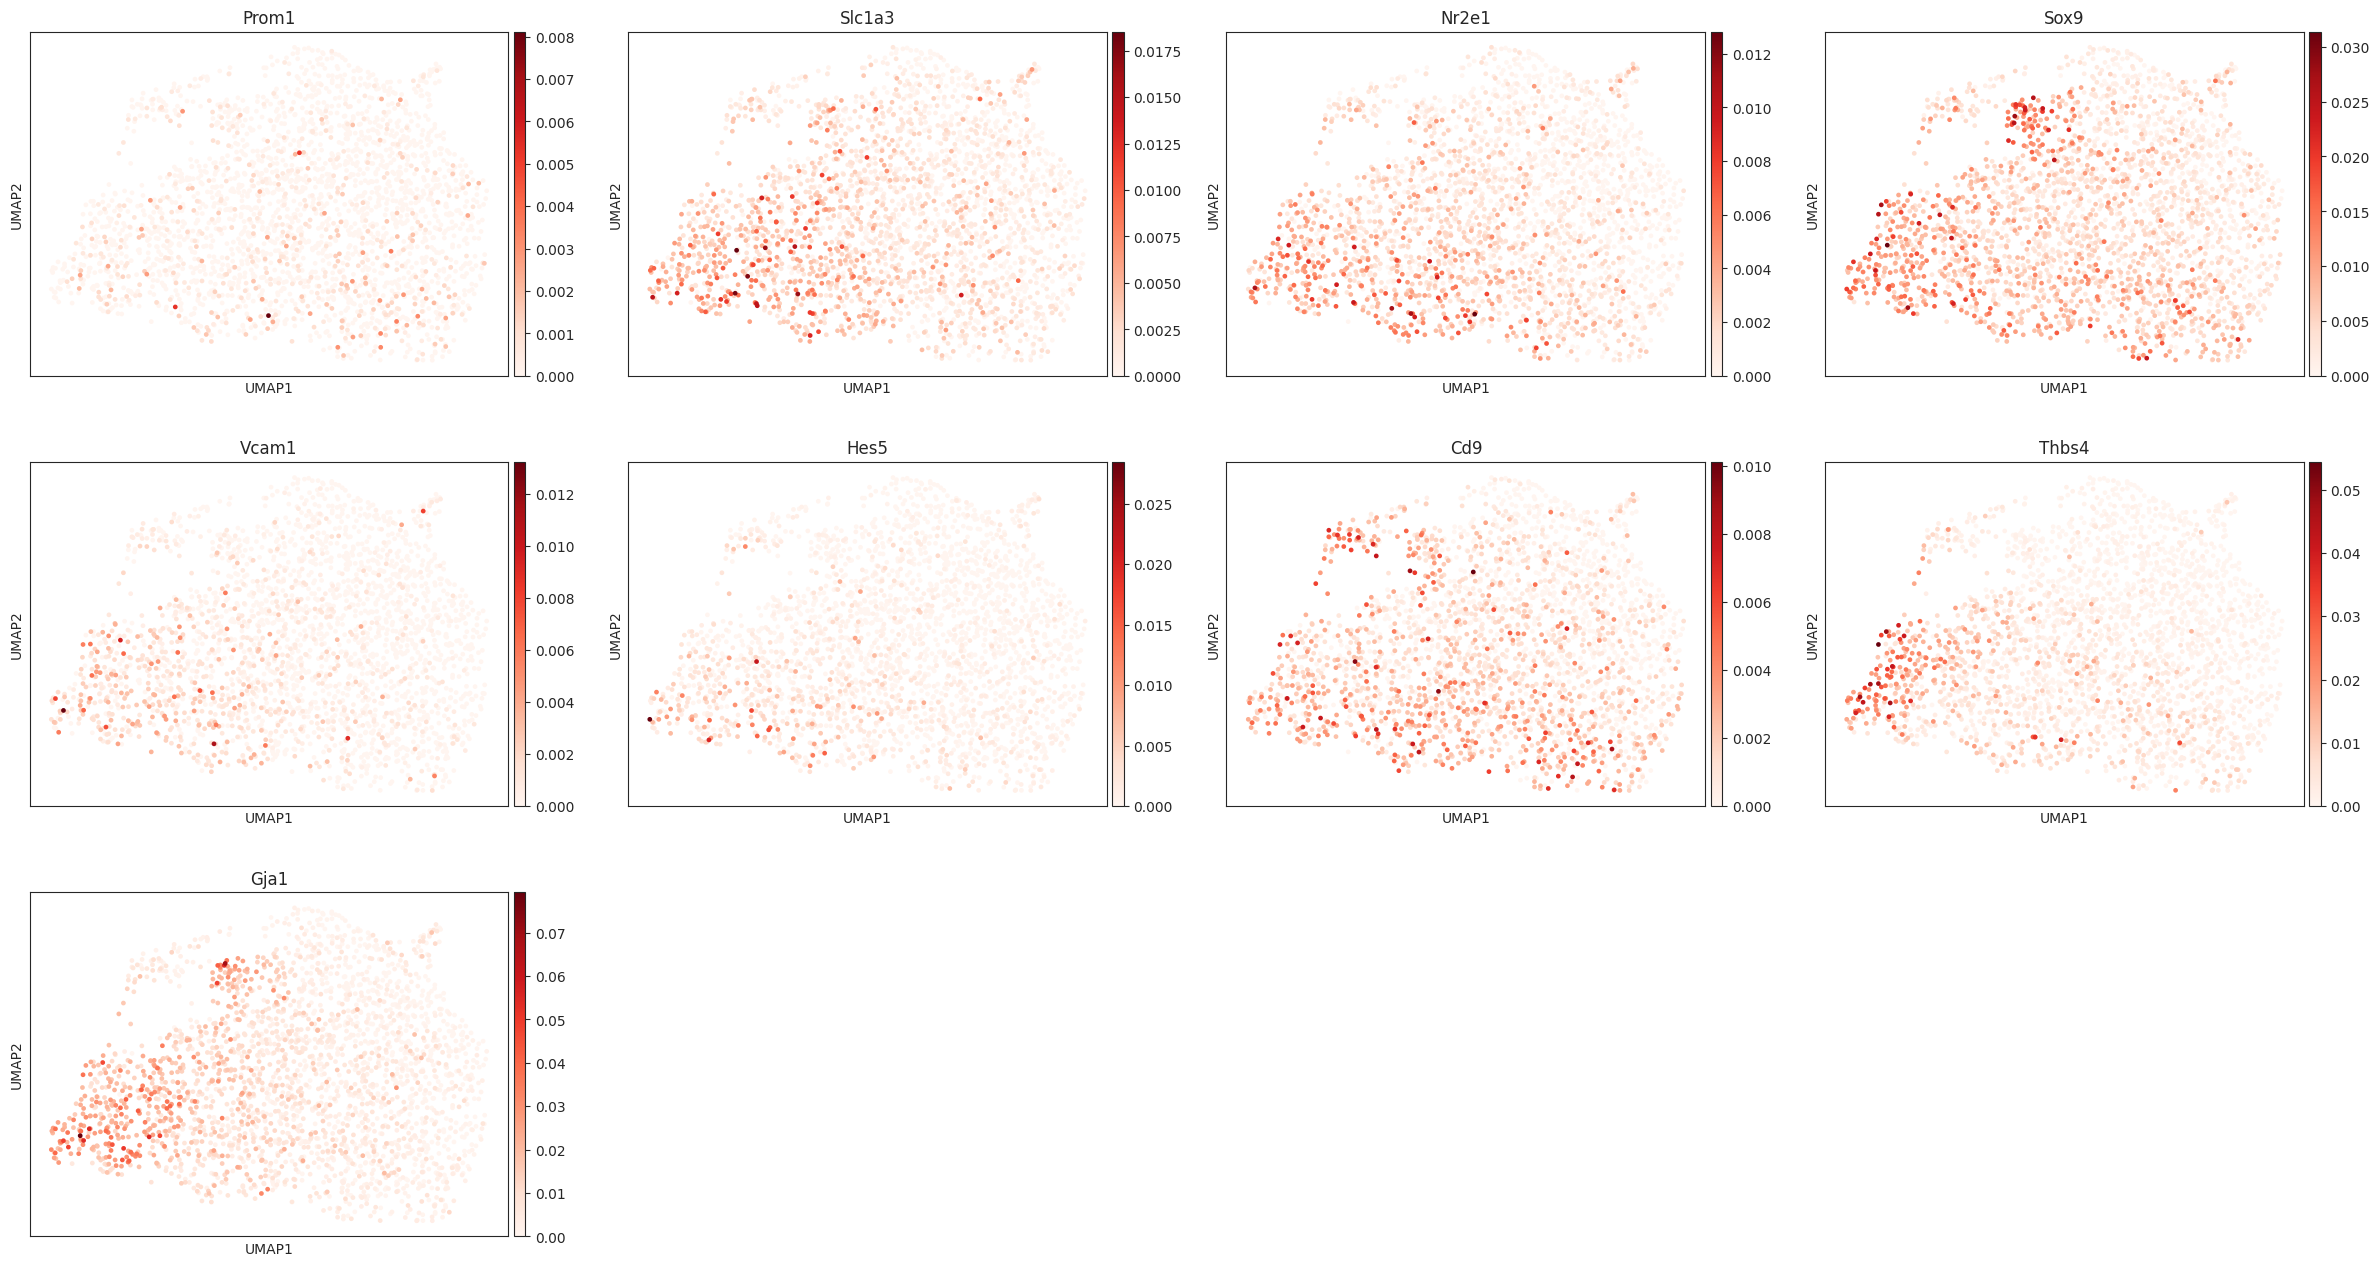

aNSC/NPC


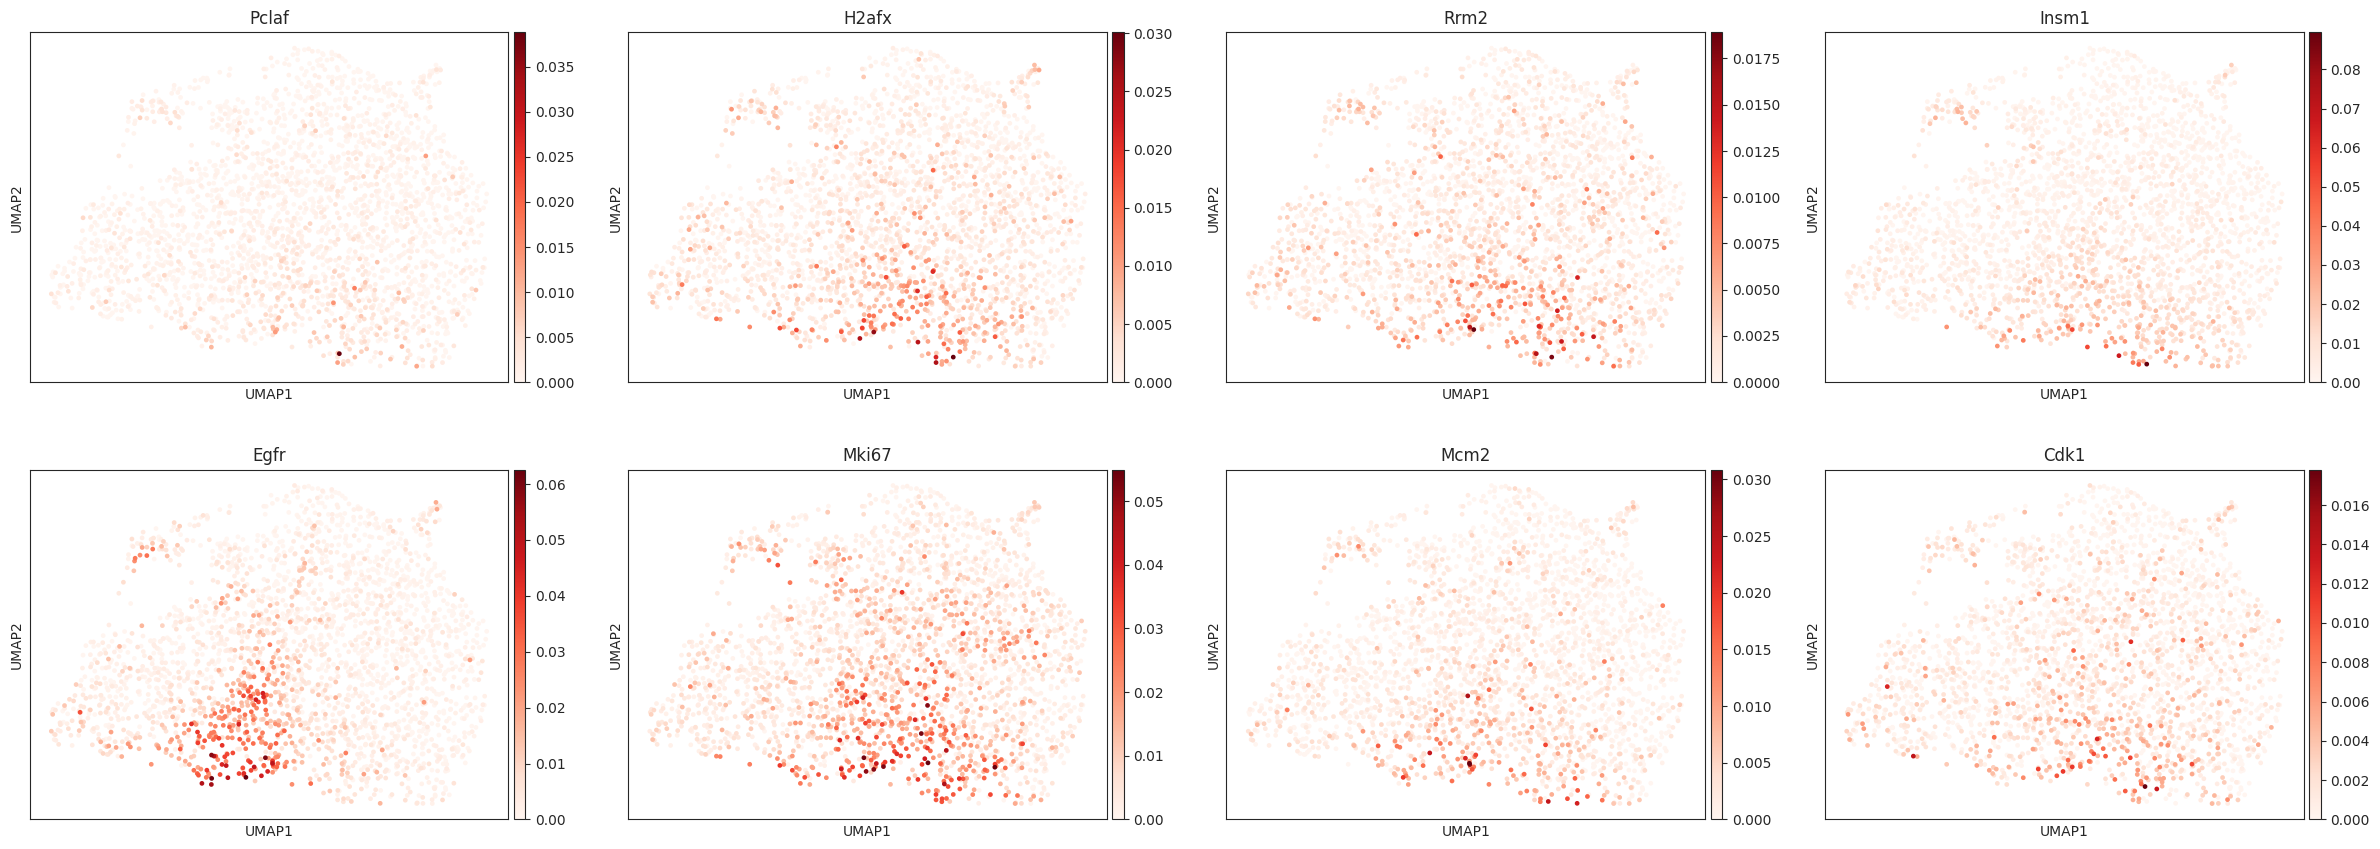

In [8]:
# show markers

major_celltype_markers_dict = {
    "Neuron":["Dpp6", "Reln"],
    "Excitatory Neuron":["Slc17a7", "Slc17a6"],
    "Inhibitory Neuron":["Slc32a1", "Gad1", "Gad2"],
    "MSN":["Drd1", "Drd2", "Adora2a"],
    "Other_Neuron":["Chat","Slc6a3","Th","Tph2"],
    "Astrocyte":["Aqp4", "Gfap", "Aldh1l1"],
    "Microglia":["Cx3cr1", "C1ql3", "Csf1r","Ccl4","C1qa","C1qb","Hexb"],
    "Oligodendrocyte":["Olig1", "Olig2", "Opalin", "Mog", "Klk6", "Cldn11"],
    "OPC":["Pdgfra", "Vcan"],
    "New_Olig":["Gpr17","Bmp4"],
    "Endothelial":["Flt1","Cldn5","Apold1","Ly6c1"],
    "LEC":["Flt4","Prox1","Pecam1","Pdpn"],
    "Hemoglobin-expressing vascular cells":["Alas2"],
    "VSMC":["Acta2"],
    "VLMC":["Slc6a13"],
    "Pericyte":["Kcnj8", "Vtn", "Ifitm1"],
    "Ependymal":["Ccdc153", "Rarres2", "Tmem212"],
    "qNSC":["Prom1", "Slc1a3", "Nr2e1", "Sox9", "Vcam1", "Hes5", "Cd9", "Thbs4", "Gja1"],
    "aNSC/NPC":["Pclaf", "H2afx", "Rrm2", "Insm1", "Egfr", "Mki67", "Mcm2", "Cdk1"],
    "Neuroblast":["Stmn2", "Dlx6os1", "Igfbpl1", "Dcx", "Cd24a", "Tubb3", "Sox11", "Dlx1"],
    "Macrophage":["Mrc1", "Pf4", "Lyz2"],
    "T cell":["Cd3e","Nkg7","Ccl5","Ms4a4b","Cd3g","Cd69","Lat"],
    "T cell (cytotoxic)":["Cd8a","Cd8b1","Gzmb","Trac"],
    "T cell (helper)":["Cd4","Ccr4","Cd28"],
    "T cell (reg)":["Ikzf2","Foxp3"],
    "T cell (tissue retention)":["Itga1","Itga4","Sell","Cd69"],
    "NK cell":["Klrd1","Klrk1","Fcgr3"],
    "B cell":["Cd79a","Cd19","Ighm","Ighd","Cd27"],
    "B cell (memory)":["Cd40"],
    "B cell (effector/plasma)":["Ly6c2","Sdc1","Ms4a1"],
    "Monocyte":["Plac8", "Ly6c1", "Cx3cr1"], # last two are for inflammatory and resident respectively
    "Dendritic cell":["Cd209a", "Flt3"],
    "Neutrophil":["S100a9","Ptprc","Itgam","Cxcr2"],
    "Mast cell":["Hdc", "Cma1"],
    "Dividing":["Top2a","Mki67","Egfr"],
}

sc.pl.umap(sub_adata, color='leiden')
for key in ["qNSC", "aNSC/NPC"]:
    print(key)
    sc.pl.umap(sub_adata, color=major_celltype_markers_dict[key], cmap='Reds', vmin=0)

In [9]:
# map new subclusters

mapping_subclusters = {
    '0': "aNSC",
    '1': "aNSC",
    '2': "qNSC",
    '3': "aNSC",
    '4': "qNSC",
    '5': "aNSC",
    '6': "qNSC",
    '7': "aNSC",
}

In [10]:
# update labels
celltype_fineres[adata.obs["celltype"]==celltype_to_subcluster] = [mapping_subclusters[i] for i in sub_adata.obs['leiden']]

In [11]:
# add new labels to anndata
adata.obs['celltype'] = celltype_fineres

# order cell types
categories_order = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'aNSC', 'qNSC',
                    'Macrophage', 'Neutrophil','T cell', 'B cell']
adata.obs['celltype'] = adata.obs['celltype'].astype('category').cat.reorder_categories(categories_order)

In [12]:
# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

In [13]:
# recompute with NSCs split


cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'aNSC', 'qNSC',
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))

/oak/stanford/scg/lab_abrunet1/Eric/MERFISH/ageaccel_proximity.py:153: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p = ttest_ind(adata.obs['normalized_age_acceleration'].copy()[near_ages=="Near"],
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/oak/stanford/scg/lab_abrunet1/Eric/MERFISH/ageaccel_proximity.py:153: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unre

/local/scratch/edsun/slrmtmp.42065913/ipykernel_36959/1520059740.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = sub_cond_df.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")


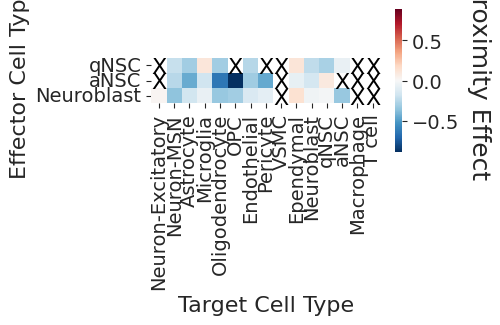

In [14]:
effector_cells = ["qNSC", "aNSC", "Neuroblast"]
receiver_cells = new_restricted_celltype_subset

###########################################################
sub_cond_df = comb_df[comb_df['Near Cell'].isin(effector_cells)]
sub_cond_df = sub_cond_df[sub_cond_df['AgeAccel Cell'].isin(receiver_cells)]
sub_cond_df["Near Cell"] = sub_cond_df["Near Cell"].astype('category').cat.reorder_categories([x for x in effector_cells if x in sub_cond_df['Near Cell'].values])
sub_cond_df["AgeAccel Cell"] = sub_cond_df["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in receiver_cells if x in sub_cond_df['AgeAccel Cell'].values])


pivot_df = sub_cond_df.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")


fig, ax = plt.subplots(figsize=(5,3))
# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 16, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.max(np.abs(sub_cond_df["Aging Effect"])),
            vmax=np.max(np.abs(sub_cond_df["Aging Effect"])))

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Target Cell Type", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"plots/proximity/celltype_proximity_age_accel_ttest_heatmap_qNSCaNSCOnly_spatialsmooth_regionmatchedfarthest_cohensd.pdf",
            bbox_inches='tight')
plt.show()

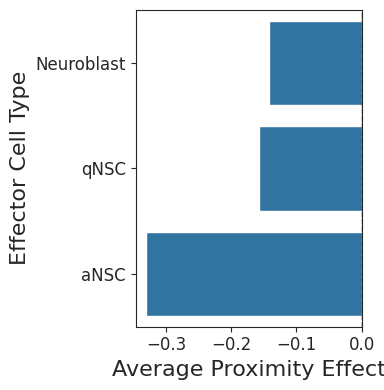

In [15]:
effector_cells = ["qNSC", "aNSC", "Neuroblast"]
receiver_cells = new_restricted_celltype_subset


#-------------------------------------------------------------
celltypes = []
average_effects = []
colors = []

sub_cond_df = comb_df[comb_df['Near Cell'].isin(effector_cells)].copy()
sub_cond_df = sub_cond_df[sub_cond_df['AgeAccel Cell'].isin(receiver_cells)]
sub_cond_df["Near Cell"] = sub_cond_df["Near Cell"].astype('category').cat.reorder_categories([x for x in effector_cells if x in sub_cond_df['Near Cell'].values])
sub_cond_df["AgeAccel Cell"] = sub_cond_df["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in receiver_cells if x in sub_cond_df['AgeAccel Cell'].values])


for ct in np.unique(sub_cond_df["Near Cell"]):
    average_effect = np.nanmean(sub_cond_df[sub_cond_df["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

plt.figure(figsize=(4,4)) # 1.5,2

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)
g.legend_.remove()

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f"plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_qNSCaNSC_RESTRICTED.pdf",
            bbox_inches='tight')
plt.show()

# Visual examples around T cells and NSC/Neuroblasts

In [ ]:
target_celltype = "T cell"
width = 100

# -----------------------------------------------
n_rows = 5
n_cols = 20


fig, axarr = plt.subplots(n_rows, n_cols, sharex=False, sharey=False, figsize=(30,8))
ages = np.sort(np.unique(adata.obs['age']))
for i in range(n_cols):
    age = ages[i]
    sub_adata = adata[(adata.obs['age']==age)].copy()
    # get first cell of target_celltype
    target_idxs = np.where(sub_adata.obs.celltype.values==target_celltype)[0]
    skip = np.max([int(np.floor(len(target_idxs)/n_cols)),1])
    target_idxs = target_idxs[::skip]
    for j in range(n_rows):
        if j < len(target_idxs):
            target_idx = target_idxs[j]
            # crop to around that cell
            center_x, center_y = (sub_adata.obsm['spatial'][target_idx,0],sub_adata.obsm['spatial'][target_idx,1])
            x1,x2,y1,y2 = (center_x-width/2,center_x+width/2,center_y-width/2,center_y+width/2)
            sub_adata_c = sub_adata[(sub_adata.obsm["spatial"][:,0]>x1)&(sub_adata.obsm["spatial"][:,0]<x2)&(sub_adata.obsm["spatial"][:,1]>y1)&(sub_adata.obsm["spatial"][:,1]<y2)].copy()
            # restrict to top clock cell types
            sub_adata_c = sub_adata_c[sub_adata_c.obs['celltype'].isin(restricted_celltype_subset)]
            sc.pl.embedding(sub_adata_c, 'spatial', color="normalized_age_acceleration", size=200, show=False,
                            title=str(age)+" months", ax=axarr[j,i],
                            vmin=-np.max(np.abs(sub_adata_c.obs.normalized_age_acceleration)),
                            vmax=np.max(np.abs(sub_adata_c.obs.normalized_age_acceleration)), cmap="RdBu_r")
            axarr[j,i].axis('off')
plt.suptitle(f"Normalized Age Acceleration ({target_celltype})", fontsize=16)
plt.tight_layout()
plt.savefig(f"plots/proximity/normalized_age_accel_cropped{width}_{target_celltype}.pdf", bbox_inches='tight')
plt.show()

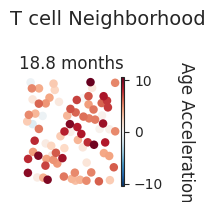

In [56]:
target_celltype = "T cell"
width = 200

i=9
j=13

# -----------------------------------------------

fig, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(2,2))
ages = np.sort(np.unique(adata.obs['age']))
age = ages[i]
sub_adata = adata[(adata.obs['age']==age)].copy()
# get first cell of target_celltype
target_idxs = np.where(sub_adata.obs.celltype.values==target_celltype)[0]
target_idxs = target_idxs[::skip]
target_idx = target_idxs[j]
# crop to around that cell
center_x, center_y = (sub_adata.obsm['spatial'][target_idx,0],sub_adata.obsm['spatial'][target_idx,1])
x1,x2,y1,y2 = (center_x-width/2,center_x+width/2,center_y-width/2,center_y+width/2)
sub_adata_c = sub_adata[(sub_adata.obsm["spatial"][:,0]>x1)&(sub_adata.obsm["spatial"][:,0]<x2)&(sub_adata.obsm["spatial"][:,1]>y1)&(sub_adata.obsm["spatial"][:,1]<y2)].copy()
# restrict to top clock cell types
sub_adata_c = sub_adata_c[sub_adata_c.obs['celltype'].isin(restricted_celltype_subset)]
sc.pl.embedding(sub_adata_c, 'spatial', color="normalized_age_acceleration", size=150, show=False,
                title=str(age)+" months", ax=axarr,
                vmin=-np.max(np.abs(sub_adata_c.obs.normalized_age_acceleration)),
                vmax=np.max(np.abs(sub_adata_c.obs.normalized_age_acceleration)), cmap="RdBu_r")
axarr.collections[0].colorbar.set_label('Age Acceleration',
                                    rotation=270, fontsize=12, labelpad=23)
axarr.axis('off')
plt.suptitle(f"{target_celltype} Neighborhood", fontsize=14)
plt.tight_layout()
plt.savefig(f"plots/proximity/normalized_age_accel_cropped{width}_{target_celltype}_{i}_{j}.pdf", bbox_inches='tight')
plt.show()

In [ ]:
target_celltype = "NSC"
width = 100

# -----------------------------------------------
n_rows = 5
n_cols = 20


fig, axarr = plt.subplots(n_rows, n_cols, sharex=False, sharey=False, figsize=(30,8))
ages = np.sort(np.unique(adata.obs['age']))
for i in range(n_cols):
    age = ages[i]
    sub_adata = adata[(adata.obs['age']==age)].copy()
    # get first cell of target_celltype
    target_idxs = np.where(sub_adata.obs.celltype.values==target_celltype)[0]
    skip = np.max([int(np.floor(len(target_idxs)/n_cols)),1])
    target_idxs = target_idxs[::skip]
    for j in range(n_rows):
        if j < len(target_idxs):
            target_idx = target_idxs[j]
            # crop to around that cell
            center_x, center_y = (sub_adata.obsm['spatial'][target_idx,0],sub_adata.obsm['spatial'][target_idx,1])
            x1,x2,y1,y2 = (center_x-width/2,center_x+width/2,center_y-width/2,center_y+width/2)
            sub_adata_c = sub_adata[(sub_adata.obsm["spatial"][:,0]>x1)&(sub_adata.obsm["spatial"][:,0]<x2)&(sub_adata.obsm["spatial"][:,1]>y1)&(sub_adata.obsm["spatial"][:,1]<y2)].copy()
            # restrict to top clock cell types
            sub_adata_c = sub_adata_c[sub_adata_c.obs['celltype'].isin(restricted_celltype_subset)]
            sc.pl.embedding(sub_adata_c, 'spatial', color="normalized_age_acceleration", size=200, show=False,
                            title=str(age)+" months", ax=axarr[j,i],
                            vmin=-np.max(np.abs(sub_adata_c.obs.normalized_age_acceleration)),
                            vmax=np.max(np.abs(sub_adata_c.obs.normalized_age_acceleration)), cmap="RdBu_r")
            axarr[j,i].axis('off')
plt.suptitle(f"Normalized Age Acceleration ({target_celltype})", fontsize=16)
plt.tight_layout()
plt.savefig(f"plots/proximity/normalized_age_accel_cropped{width}_{target_celltype}.pdf", bbox_inches='tight')
plt.show()

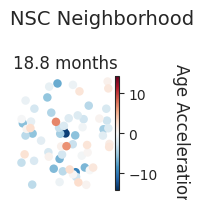

In [57]:
target_celltype = "NSC"
width = 200

i=9
j=0

# -----------------------------------------------

fig, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(2,2))
ages = np.sort(np.unique(adata.obs['age']))
age = ages[i]
sub_adata = adata[(adata.obs['age']==age)].copy()
# get first cell of target_celltype
target_idxs = np.where(sub_adata.obs.celltype.values==target_celltype)[0]
target_idxs = target_idxs[::skip]
target_idx = target_idxs[j]
# crop to around that cell
center_x, center_y = (sub_adata.obsm['spatial'][target_idx,0],sub_adata.obsm['spatial'][target_idx,1])
x1,x2,y1,y2 = (center_x-width/2,center_x+width/2,center_y-width/2,center_y+width/2)
sub_adata_c = sub_adata[(sub_adata.obsm["spatial"][:,0]>x1)&(sub_adata.obsm["spatial"][:,0]<x2)&(sub_adata.obsm["spatial"][:,1]>y1)&(sub_adata.obsm["spatial"][:,1]<y2)].copy()
# restrict to top clock cell types
sub_adata_c = sub_adata_c[sub_adata_c.obs['celltype'].isin(restricted_celltype_subset)]
sc.pl.embedding(sub_adata_c, 'spatial', color="normalized_age_acceleration", size=150, show=False,
                title=str(age)+" months", ax=axarr,
                vmin=-np.max(np.abs(sub_adata_c.obs.normalized_age_acceleration)),
                vmax=np.max(np.abs(sub_adata_c.obs.normalized_age_acceleration)), cmap="RdBu_r")
axarr.collections[0].colorbar.set_label('Age Acceleration',
                                    rotation=270, fontsize=12, labelpad=23)
axarr.axis('off')
plt.suptitle(f"{target_celltype} Neighborhood", fontsize=14)
plt.tight_layout()
plt.savefig(f"plots/proximity/normalized_age_accel_cropped{width}_{target_celltype}_{i}_{j}.pdf", bbox_inches='tight')
plt.show()